In [1]:
import os
from __future__ import division
import datetime
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import solvers, matrix
import tushare as ts
%matplotlib inline
os.chdir("d://R_work//mo2")

In [ ]:
def get_weights(retData):
    
    cov_mat = get_covmat(retData)
    # 根据上面的描述写好对应的P、q、G、h、A、b
    Nums = cov_mat.shape[0]
    P = matrix(cov_mat.values)
    q = matrix(np.zeros(Nums))
    G = matrix(np.diag(-np.ones(Nums)))
    h = matrix(np.zeros(Nums))
    A = matrix(np.ones(Nums)).T
    b = matrix(1.0).T

    # 代入优化方程求解
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    wts = pd.Series(index=cov_mat.index, data=np.array(sol['x']).flatten())
    wts = wts[wts >= 0.0001]  # weights调整，对于权重太小的不予配置
    wts_adjusted = wts / wts.sum() * 1.0
    return wts_adjusted

In [2]:
# Benchmark自2014累计收益率
def rawData(filename,start_date = pd.datetime.today().date() - datetime.timedelta(90)
,end_date=pd.datetime.today().date()):
    data = pd.read_csv(filename+".csv")
    dt = data["date"].apply(lambda x: pd.to_datetime(x).date())  # turn to date
    data.set_index(dt, inplace=True, drop=True)# set index
    data.sort_index(ascending=True, inplace=True)
    data = data[(data.index >= pd.to_datetime(start_date).date()) & (data.index <  pd.to_datetime(end_date).date())] # 选择时间范围
    data = data[['price']]
    data.columns = [filename]
    return data


In [3]:
def benchmarkRaw(secList, start_date = pd.datetime.today().date() - datetime.timedelta(90), end_date=pd.datetime.today().date()):
    # concat the benchmark
    da = []
    for each in secList:
        print each
        if each in ['hs300']:
            data = ts.get_hist_data(each, start_date, end_date)
            dt = pd.Series(data.index.values).apply(lambda x: pd.to_datetime(x).date())
            data.set_index(dt, inplace=True, drop=True)# set index
            data.sort_index(ascending=True, inplace=True)
            da += [data['close']]
        else:
            hist_data_each = rawData(each, start_date, end_date)
            da += [hist_data_each]
    data = pd.concat(da, axis=1)
    data.columns = secList
    data = data.dropna(axis = 0, how = 'any')
    cumRetdata = data.apply(lambda df: df / df [0]) -1 # 按照基准为%0计算超额收益
    cumRetdata = cumRetdata.dropna(axis = 0, how = 'any')
    return data, cumRetdata


In [4]:
def get_annual_pct_ret(data):
    return data.pct_change().dropna()

def get_annual_log_ret(data):
    return np.log(data.diff()).dropna()

def get_covmat(retData, tradeDay=252):
    return retData.cov()*tradeDay

def plot_capm(start_dt, end_dt, dropn = 1, mc = 10000, Rf = 0.04):
    port_returns = []
    port_variance = []
    data = benchmarkRaw(secList, start_dt, end_dt)[0]
    retData = data.pct_change().dropna()
    retData = retData[secList[:-dropn]] # drop hs300 217004BI
    # print cov_mat
    cov_mat = get_covmat(retData)*100
    print cov_mat
    noa = cov_mat.shape[0]
    for p in range(mc):
        weights = np.random.random(noa)
        weights /= np.sum(weights)
        port_returns.append(np.sum(retData.mean()*252*weights))
        port_variance.append(np.sqrt(np.dot(weights.T, np.dot(retData.cov()*252, weights))))
    
    port_returns = np.array(port_returns)
    port_variance = np.array(port_variance)

    #无风险利率设定为4%
    risk_free = 0.0443
    plt.figure(figsize = (10,5))
    plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
    plt.grid(True)
    plt.xlabel('excepted volatility')
    plt.ylabel('expected return')
    plt.colorbar(label = 'Sharpe ratio')
    plt.title(start_dt + "--" + end_dt + " MC Simulation")

SEC.885004
SEC.885005
SEC.885068
SEC.217004BI
hs300
              SEC.885004  SEC.885005  SEC.885068  SEC.217004BI
SEC.885004      2.026840    0.108395   -0.062023      0.000242
SEC.885005      0.108395    0.010666   -0.000326      0.000154
SEC.885068     -0.062023   -0.000326    0.457093     -0.000670
SEC.217004BI    0.000242    0.000154   -0.000670      0.000060


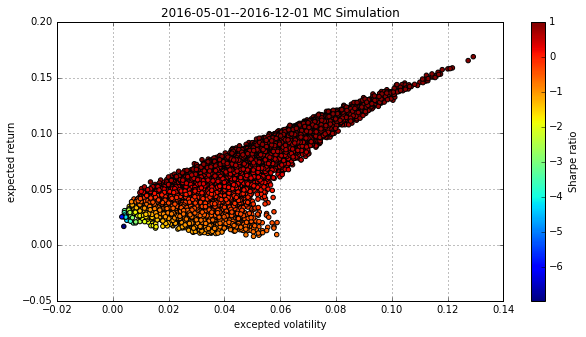

In [5]:
secList = ["SEC.885004", "SEC.885005", "SEC.885068", "SEC.217004BI" , "hs300"]
# benchmarkdata, benchRetCumData = benchmarkRaw(secList, '2016-04-28', '2016-12-01')
plot_capm('2016-05-01', '2016-12-01', 1, 20000)

SEC.885004
SEC.885005
SEC.885068
SEC.217004BI
hs300
              SEC.885004  SEC.885005  SEC.885068  SEC.217004BI
SEC.885004      3.306963    0.193327   -0.055578      0.000493
SEC.885005      0.193327    0.017254    0.000694      0.000074
SEC.885068     -0.055578    0.000694    0.439917     -0.000047
SEC.217004BI    0.000493    0.000074   -0.000047      0.000037


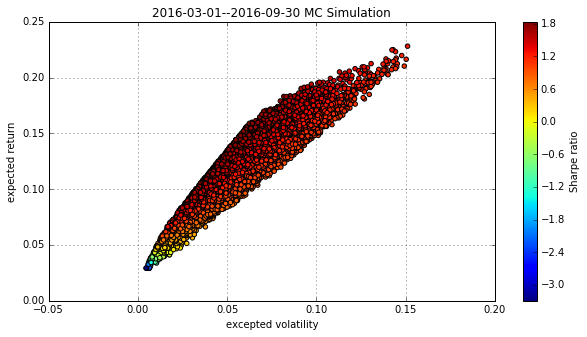

In [6]:
plot_capm('2016-03-01', '2016-09-30',1, 20000)

SEC.885004
SEC.885005
SEC.885068
SEC.217004BI
hs300
              SEC.885004  SEC.885005  SEC.885068  SEC.217004BI
SEC.885004      6.330141    0.355462   -0.202904      0.000133
SEC.885005      0.355462    0.027863   -0.009202      0.000122
SEC.885068     -0.202904   -0.009202    0.591607     -0.000788
SEC.217004BI    0.000133    0.000122   -0.000788      0.000062


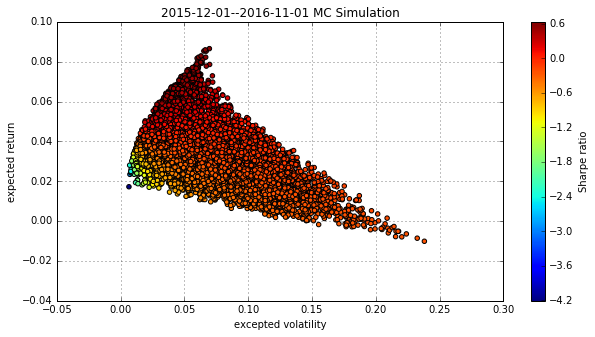

In [13]:
plot_capm('2015-12-01', '2016-11-01',1, 20000)

SEC.885004
SEC.885005
SEC.885068
SEC.217004BI
hs300
              SEC.885004  SEC.885005  SEC.885068  SEC.217004BI
SEC.885004      9.487422    0.509600   -0.301487     -0.000192
SEC.885005      0.509600    0.037537   -0.016722      0.000154
SEC.885068     -0.301487   -0.016722    0.592924     -0.000761
SEC.217004BI   -0.000192    0.000154   -0.000761      0.000061


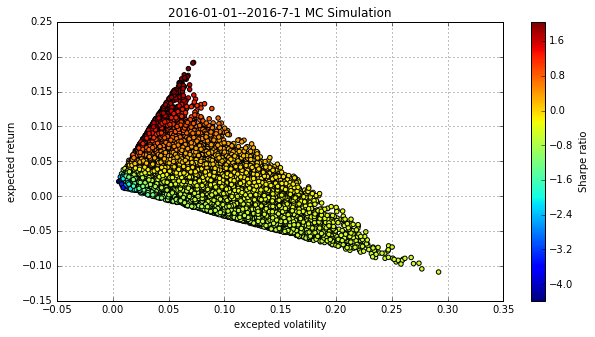

In [12]:
plot_capm('2016-01-01', '2016-7-1',1, 20000)

SEC.885004
SEC.885005
SEC.885068
SEC.217004BI
hs300
              SEC.885004  SEC.885005  SEC.885068  SEC.217004BI
SEC.885004      2.461539    0.143007   -0.039140      0.001089
SEC.885005      0.143007    0.014565    0.002593      0.000181
SEC.885068     -0.039140    0.002593    0.388613     -0.000633
SEC.217004BI    0.001089    0.000181   -0.000633      0.000060


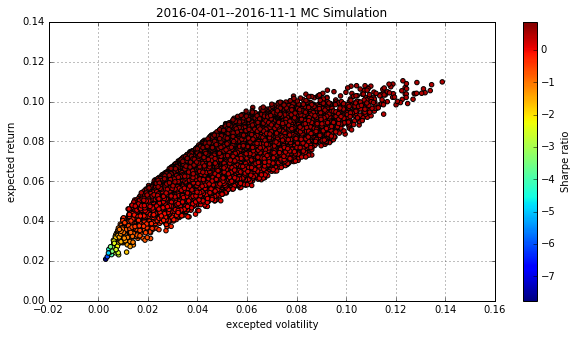

In [8]:
plot_capm('2016-04-01', '2016-11-1',1, 20000)